# Main Analysis of Truck Data
This notebook contains functions to graph SPL and its correlation to truck sounds (as determined by clustering).

Import statements

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import PolynomialFeatures
import datetime 
from datetime import timedelta
import pytz
from pytz import timezone
import tarfile
from numpy import load
import os
from sklearn.manifold import TSNE
import h5py
from sklearn.decomposition import PCA as sklearnPCA
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import datasets
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import DBSCAN
from sklearn.cluster import Birch
import scipy
from scipy import spatial
from scipy import stats
import pylab
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import librosa
from scipy import signal
from scipy import ndimage
import matplotlib.dates as md
import sys

Loading the hdf5 files

In [2]:
h5 = h5py.File('data/sound_data_improved.hdf5', 'r')

In [3]:
d = h5['sound_data']

# Creating subsample of 10000 points from all four sensors

In [4]:
sample_nums = np.random.choice(range(d.shape[0]), 10000, replace = False)

In [5]:
index = np.zeros(d.shape[0]).astype('bool')
index[sample_nums] = True

# Reading and graphing data from one sensor

Reading June data from one of the sensors

In [6]:
df = pd.read_csv("data/sonycnode-b827ebc178d2.sonyc.csv", skiprows = 2, low_memory = False)
df.head()

,timestamp,dBAS
0,1.559362e+09,63.53
1,1.559362e+09,63.73
2,1.559362e+09,64.94
3,1.559362e+09,63.09
4,1.559362e+09,61.66


Creating two numpy array with the timestamps for June and the corresponding SPL values for June

In [7]:
time_arr = np.empty(df.shape[0], dtype = datetime.datetime)
timestamp_arr = df['timestamp'].values
dBAS_arr = df['dBAS'].values

A function to convert the UNIX timestamps to datetime objects for easier interpretation 

In [8]:
def convert_timestamps(sensor_timestamp):
    """
    Converts a float timestamp to a datetime object.
    
    Parameters
    ----------
    sensor_timestamp : float
        A timestamp in float form.
        
    Returns
    -------
    dt : datetime object
       Datetime object corresponding to the same time as the float timestamp.
    """
    j = sensor_timestamp
    dt = datetime.datetime.utcfromtimestamp(j)
    dt = pytz.UTC.localize(dt)
    dt = dt.astimezone(pytz.timezone('US/Eastern'))
    return dt

Converting the UNIX timestamps to datetime format using above function

In [9]:
time_arr = [convert_timestamps(x) for x in timestamp_arr]

Creating a new dataframe with timestamps in datetime format

In [10]:
time_df = df
time_df['timestamp'] = time_arr
time_df.tail()

,timestamp,dBAS
2589895,2019-07-01 00:00:38.810000-04:00,66.04
2589896,2019-07-01 00:00:39.810000-04:00,69.75
2589897,2019-07-01 00:00:40.810000-04:00,68.68
2589898,2019-07-01 00:00:41.810000-04:00,73.17
2589899,2019-07-01 00:00:42.810000-04:00,77.04


# Clustering on 45 dimensions

Running PCA on the embeddings in order to reduce dimensionality to 45

In [166]:
pca_45 = sklearnPCA(45)
projected_45 = pca_45.fit_transform(d['feature_vector'])

KeyboardInterrupt: 

Function to get a boolean mask to filter data to only get data from a certain sensor

In [12]:
def get_sensor_mask(sensor_name, target_arr):
    """
    Returns a mask to apply on an array of data from different sensors. The mask filters out the data from one sensor.
    
    Parameters
    ----------
    sensor_name : String
        The name of the sensor to retrieve the data for, should take the form of b'sonycnode-[name].sonyc'
    
    target_arr : array of Strings
        Array containing the names of all the sensors.
        
    Returns
    -------
    sensor_mask : boolean array
        A boolean array of the same shape as target_arr, with True values corresponding to the indices containing the
        sensor_name.
    """
    sensor_mask = (target_arr == sensor_name)
    return sensor_mask

Function to get a boolean mask to filter data to only get data between two times

In [13]:
def get_time_mask(beginning, end, time_arr):
    """
    Returns a boolean mask to apply to a datetime array, with the goal of returning times between a beginning and 
    end time, including the beginning time but excluding the end time. 
    
    Parameters
    ----------
    beginning : datetime.datetime
        The beginning time to use for the mask.
        
    end : datetime.datetime
        The end time to use for the mask.
        
    time_arr : np array
        A numpy array of naive datetime objects. The mask will be applied to this array.
        
    Returns
    -------
    interval_mask : boolean array
        A boolean array to use as a mask on time_arr.
    """
    interval_mask = (time_arr >= beginning) & (time_arr < end)
    return interval_mask

Function to get cluter assignments for each embedding

In [14]:
def get_cluster_assignments(num_clusters, sensor_transformed, fit_arr):
    """
    Returns an array containing the number of each cluster each data point in sensor_transformed is assigned to.
    Clustering is performed using MiniBatchKMeans.
    
    Parameters
    ----------
    num_clusters : int
        The number of clusters to group sensor_transformed into.
        
    sensor_transformed : array of floats
        45-dimensional array of feature vectors from one sensor 
        
    fit_arr : array of floats
        45-dimensional array of feature vectors from all sensors
        
    Returns
    -------
    cluster_indices : int array
        An array with the index of the cluster that each data point belongs to.
        
    """
    mbk = MiniBatchKMeans(n_clusters=num_clusters, random_state=0)
    mbk.fit(fit_arr)
    cluster_indices = mbk.predict(sensor_transformed)
    return cluster_indices

Function to return the number of hours since the beginning of a month from a timestamp

In [15]:
def convert_to_hour(sensor_timestamp):
    """
    Returns the number of hours since the beginning of the month of a timestamp in Unix format. For example, 
    if the timestamp converts to 9:00 am on June 2nd, 57 (e.g. 48 + 9) would be returned.
    
    Parameters
    ----------
    sensor_timestamp : float
        A Unix timestamp.
        
    Returns
    -------
   total_hour : int
        The number of hours since the beginning of the month of the recording date. 
    """
    j = sensor_timestamp[i]
    dt = datetime.datetime.utcfromtimestamp(j)
    dt = pytz.UTC.localize(dt)
    day = dt.astimezone(pytz.timezone('US/Eastern')).day
    hour = dt.astimezone(pytz.timezone('US/Eastern')).hour
    total_hour = 24*(day-1) + hour
    return total_hour

In [16]:
def get_y_and_bins(num_clusters, sensor_transformed, fit_arr, sensor_timestamps_dt, default_bins, clusters_plot_arr):
    """
    Returns y values and bin values for a histogram of data. Used to determine the bin values for plotting the 
    histogram.
    
    Parameters
    ----------
    num_clusters : int
        The number of clusters to assign the data to.
        
    sensor_transformed : 45-dimensional array of floats
        An array taken from projected_45 with only the feature vectors corresponding to one sensor.
        
    fit_arr : array of floats
        45-dimensional array of feature vectors from all sensors
        
    sensor_timestamps_dt : datetime array
        Numpy array with dtype=datetime.datetime, containing day values for each data point gathered for a specified
        sensor.
        
    default_bins : int
        Number of bins to group the data into at first.
        
    clusters_plot_arr : int array
        The list of cluster indices to plot.
        
    Returns
    -------
    y : float array
        Array of y values for the histogram
        
    bins : float array
        Array of bin values, to input in the actual histogram plot so it accurately reflects units of time (e.g. days)
        
    """
    
    test = get_cluster_assignments(num_clusters, sensor_transformed, fit_arr)

    cluster_mask = np.nonzero(test==clusters_plot_arr[0]) #boolean mask for specific cluster number
        
    #Makes array of all timestamps where cluster assignment occurred
    timestamp_arr = np.asarray(sensor_timestamps_dt)[cluster_mask]
        
    #Get y values, bins
    y, bins, _ = plt.hist(timestamp_arr, bins=default_bins)
    
    return y, bins

Function to plot a histogram of the frequency of cluster assignments over time.

In [17]:
def plot_clusters(num_clusters, sensor_transformed, fit_arr, sensor_timestamps_dt, spl_time, spl_dBAS_mean, \
                  spl_dBAS_max, spl_dBAS_median, num_bins, clusters_plot_arr):
    """
    Plots a histogram of the frequency of cluster assignments over time for one sensor.
    
    Parameters
    ----------
    num_clusters : int
        The number of clusters to assign the data to.
        
    sensor_transformed : 45-dimensional array of floats
        An array taken from projected_45 with only the feature vectors corresponding to one sensor.
        
    fit_arr : array of floats
        45-dimensional array of feature vectors from all sensors
        
    sensor_timestamps_dt : datetime array
        Numpy array with dtype=datetime.datetime, containing day values for each data point gathered for a specified
        sensor.
        
    spl_time : datetime array
        Array of datetime objects corresponding to the SPL values.
        
    spl_dBAS_mean : array of floats
        Array of SPL values corresponding to spl_time, averaged over each minute.
        
    spl_dBAS_max : array of floats
        Array of SPL values corresponding to spl_time, consisting of the maximum value from each minute.
        
    spl_dBAS_median : array of floats
        Array of SPL values corresponding to spl_time, consisting of the median value from each minute.
    
    num_bins : int
        The number of bins to group the cluster frequency into.
        
    bin_arr : array of floats
        Array of bin edges to group the cluster frequency into.
        
    clusters_plot_arr : arr of ints within the range(0, num_clusters)
        The indices of the clusters to plot.
    """
    
    #Setting the figure size, layout
    fig = plt.figure(figsize=(15,100), dpi=60)
    subplot_idx = 1
    y_vals = [] #array of all y values, used to get ylim for graph

    test = get_cluster_assignments(num_clusters, sensor_transformed, fit_arr)

    for cluster_num in clusters_plot_arr:
        cluster_mask = np.nonzero(test==cluster_num) #boolean mask for specific cluster number
        
        #If there are no instances of this cluster in the cluster assignments, don't graph
        if(np.sum(cluster_mask) == 0):
            continue
        
        
        #Makes array of all timestamps where cluster assignment occurred
        timestamp_arr = np.asarray(sensor_timestamps_dt)[cluster_mask]
        
        ax1 = fig.add_subplot(num_clusters, 1, subplot_idx)  
        color = 'tab:red'
        ax1.set_xlabel('time')
        ax1.set_ylabel('cluster ' + str(cluster_num), color=color)
    
        #Get y values, bins
        if(cluster_num == clusters_plot_arr[0]):
            y, bins, _ = ax1.hist(timestamp_arr, bins=num_bins, color=color)

        ax1.hist(timestamp_arr, bins=bins, color=color)
        y_vals.append(y.max())
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:blue'
        ax2.set_ylabel('dBAS', color=color)  # we already handled the x-label with ax1
        ax2.plot(spl_time, spl_dBAS_mean, color=color)
        ax2.plot(spl_time, spl_dBAS_max, color='black')
        ax2.plot(spl_time, spl_dBAS_median, color='green')
        ax2.tick_params(axis='y', labelcolor=color)

        subplot_idx += 1 
        ax1.set_ylim([0,max(y_vals)])
    
    plt.tight_layout()
    plt.show()
    return bins

In [18]:
def plot_truck_clusters_all_measures(num_clusters, sensor_transformed, fit_arr, sensor_timestamps_dt, spl_time, spl_dBAS_mean, \
                  spl_dBAS_max, spl_dBAS_median, y_vals, bin_arr, clusters_plot_arr):
    """
    Plots a histogram of the frequency of cluster assignments over time for one sensor.
    
    Parameters
    ----------
    num_clusters : int
        The number of clusters to assign the data to.
        
    sensor_transformed : 45-dimensional array of floats
        An array taken from projected_45 with only the feature vectors corresponding to one sensor.
        
    fit_arr : array of floats
        45-dimensional array of feature vectors from all sensors
        
    sensor_timestamps_dt : datetime array
        Numpy array with dtype=datetime.datetime, containing day values for each data point gathered for a specified
        sensor.
        
    spl_time : datetime array
        Array of datetime objects corresponding to the SPL values.
        
    spl_dBAS_mean : array of floats
        Array of SPL values corresponding to spl_time, averaged over each minute.
        
    spl_dBAS_max : array of floats
        Array of SPL values corresponding to spl_time, consisting of the maximum value from each minute.
        
    spl_dBAS_median : array of floats
        Array of SPL values corresponding to spl_time, consisting of the median value from each minute.
        
    y_vals : array of floats
        array of y values used to calculate the ylim.
        
    bin_arr : array of floats
        Array of bin edges to group the cluster frequency into.
        
    clusters_plot_arr : arr of ints within the range(0, num_clusters)
        The indices of the clusters to plot.
    """
    test = get_cluster_assignments(num_clusters, sensor_transformed, fit_arr)
    
    total_timestamp_arr = []
    y_maxes = [y_vals.max()] #list of all maxes of y values for each cluster number
    for cluster_num in clusters_plot_arr:
        cluster_mask = np.nonzero(test==cluster_num)
        
        if(np.sum(cluster_mask) == 0):
            continue
            
        timestamp_arr = np.asarray(sensor_timestamps_dt)[cluster_mask]
        for timestamp in timestamp_arr:
            total_timestamp_arr.append(timestamp)
    
    fig, ax1 = plt.subplots()  
    color = 'tab:red'
    ax1.set_xlabel('time')
    ax1.set_ylabel('truck clusters', color=color)
        
    y, x, _ = ax1.hist(total_timestamp_arr, bins=bin_arr, color=color)
    y_maxes.append(y.max()) #might need to fix later
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('dBAS', color=color)  # we already handled the x-label with ax1
    ax2.plot(spl_time, spl_dBAS_mean, color=color)
    ax2.plot(spl_time, spl_dBAS_max, color='black')
    ax2.plot(spl_time, spl_dBAS_median, color='green')
    ax2.tick_params(axis='y', labelcolor=color)

    ax1.set_ylim([0,max(y_maxes)])
    
    fig.set_size_inches(18.5, 10.5)
    fig.tight_layout()
    fig.show()

Getting timestamp, embedding data for one sensor

In [19]:
b827ebc178d2_mask = get_sensor_mask(d['sensor_id'], b'sonycnode-b827ebc178d2.sonyc')
b827ebc178d2_transformed = projected_45[b827ebc178d2_mask]
b827ebc178d2_timestamps = d[b827ebc178d2_mask, 'timestamp']
b827ebc178d2_timestamps_dt = [convert_timestamps(x) for x in b827ebc178d2_timestamps]

# Averaging data

Dataset with one data point every minute

In [20]:
minute_time_arr = np.empty(int(len(time_arr)/60), dtype = datetime.datetime)
minute_dBAS_arr = np.empty(int(len(time_arr)/60))

In [21]:
step = 60
i = 0
count = 0
while i < len(time_arr): 
    minute_time_arr[count] = time_arr[i]
    minute_dBAS_arr[count] = np.average(dBAS_arr[i:i+step])
    i += step
    count += 1

In [22]:
minute_time_arr

array([datetime.datetime(2019, 6, 1, 0, 0, 42, 690000, tzinfo=<DstTzInfo 'US/Eastern' EDT-1 day, 20:00:00 DST>),
       datetime.datetime(2019, 6, 1, 0, 1, 42, 700000, tzinfo=<DstTzInfo 'US/Eastern' EDT-1 day, 20:00:00 DST>),
       datetime.datetime(2019, 6, 1, 0, 2, 42, 710000, tzinfo=<DstTzInfo 'US/Eastern' EDT-1 day, 20:00:00 DST>),
       ...,
       datetime.datetime(2019, 6, 30, 23, 57, 43, 790000, tzinfo=<DstTzInfo 'US/Eastern' EDT-1 day, 20:00:00 DST>),
       datetime.datetime(2019, 6, 30, 23, 58, 43, 800000, tzinfo=<DstTzInfo 'US/Eastern' EDT-1 day, 20:00:00 DST>),
       datetime.datetime(2019, 6, 30, 23, 59, 43, 810000, tzinfo=<DstTzInfo 'US/Eastern' EDT-1 day, 20:00:00 DST>)],
      dtype=object)

# Taking max of data

In [23]:
minute_dBAS_max = np.empty(int(len(time_arr)/60))

In [24]:
step = 60
i = 0
count = 0
while i < len(time_arr): 
    minute_dBAS_max[count] = np.amax(dBAS_arr[i:i+step])
    i += step
    count += 1

In [25]:
minute_dBAS_max

array([73.88, 73.14, 81.78, ..., 74.38, 75.82, 77.04])

# Taking median of data

In [26]:
minute_dBAS_median = np.empty(int(len(time_arr)/60))

In [27]:
step = 60
i = 0
count = 0
while i < len(time_arr): 
    minute_dBAS_median[count] = np.median(dBAS_arr[i:i+step])
    i += step
    count += 1

In [28]:
minute_dBAS_median

array([61.775, 57.79 , 64.23 , ..., 58.02 , 66.055, 61.44 ])

# Plotting 12 hour intervals for one day

Slicing the SPL data

In [29]:
naive_minute_time_arr = [x.replace(tzinfo=None) for x in minute_time_arr]

Slicing for 8am to 8pm

In [30]:
naive_minute_time_arr_np = np.array(naive_minute_time_arr)
minute_time_arr_am_mask = \
get_time_mask(datetime.datetime(2019, 6, 1, 8), datetime.datetime(2019, 6, 1, 20), naive_minute_time_arr_np)

In [31]:
minute_time_arr_am = minute_time_arr[minute_time_arr_am_mask]
minute_dBAS_arr_am = minute_dBAS_arr[minute_time_arr_am_mask]
minute_dBAS_max_am = minute_dBAS_max[minute_time_arr_am_mask]
minute_dBAS_median_am = minute_dBAS_median[minute_time_arr_am_mask]

Slicing for 8pm to 8am

In [32]:
minute_time_arr_pm_mask = \
get_time_mask(datetime.datetime(2019, 6, 1, 20), datetime.datetime(2019, 6, 2, 8), naive_minute_time_arr_np)

In [33]:
minute_time_arr_pm = minute_time_arr[minute_time_arr_pm_mask]
minute_dBAS_arr_pm = minute_dBAS_arr[minute_time_arr_pm_mask]
minute_dBAS_max_pm = minute_dBAS_max[minute_time_arr_pm_mask]
minute_dBAS_median_pm = minute_dBAS_median[minute_time_arr_pm_mask]

Slicing the feature vectors from 8am to 8pm

In [34]:
naive_b827ebc178d2_timestamps_dt = [x.replace(tzinfo=None) for x in b827ebc178d2_timestamps_dt]

In [35]:
naive_b827ebc178d2_timestamps_dt_np = np.array(naive_b827ebc178d2_timestamps_dt)
am_mask = \
get_time_mask(datetime.datetime(2019, 6, 1, 8), datetime.datetime(2019, 6, 1, 20), naive_b827ebc178d2_timestamps_dt_np)

In [36]:
b827ebc178d2_timestamps_dt_am = np.asarray(b827ebc178d2_timestamps_dt)[am_mask]

Slicing the feature vectors from 8pm to 8am

In [37]:
pm_mask = \
get_time_mask(datetime.datetime(2019, 6, 1, 20), datetime.datetime(2019, 6, 2, 8), naive_b827ebc178d2_timestamps_dt_np)

In [38]:
b827ebc178d2_timestamps_dt_pm = np.asarray(b827ebc178d2_timestamps_dt)[pm_mask]

In [39]:
# plot_clusters(15, b827ebc178d2_transformed[am_mask], projected_45[index], b827ebc178d2_timestamps_dt_am, \
#              minute_time_arr_am, minute_dBAS_arr_am, 12*60)

# Plotting 1 hour intervals

Slicing the SPL data

Slicing for 2pm to 3pm

In [40]:
minute_time_arr_hour_mask = \
get_time_mask(datetime.datetime(2019, 6, 1, 14), datetime.datetime(2019, 6, 1, 15), naive_minute_time_arr_np)

In [41]:
minute_time_arr_hour = minute_time_arr[minute_time_arr_hour_mask]
minute_dBAS_arr_hour = minute_dBAS_arr[minute_time_arr_hour_mask]
minute_dBAS_max_hour = minute_dBAS_max[minute_time_arr_hour_mask]
minute_dBAS_median_hour = minute_dBAS_median[minute_time_arr_hour_mask]

Slicing the feature vectors from 2pm to 3pm

In [42]:
hour_mask = \
get_time_mask(datetime.datetime(2019, 6, 1, 14), datetime.datetime(2019, 6, 1, 15), naive_b827ebc178d2_timestamps_dt_np)

In [43]:
b827ebc178d2_timestamps_dt_hour = np.asarray(b827ebc178d2_timestamps_dt)[hour_mask]

# Plotting truck clusters

Truck clusters (in 64 cluster model) are 5, 10, 11, 18, 20, 37, 42, 57, 63

In [44]:
truck_clusters = [5, 10, 11, 18, 20, 37, 42, 57, 63]

In [45]:
# am_bins = plot_clusters(64, b827ebc178d2_transformed[am_mask], projected_45[index], b827ebc178d2_timestamps_dt_am, \
#              minute_time_arr_am, minute_dBAS_arr_am, minute_dBAS_max_am, minute_dBAS_median_am, \
#               12*60, truck_clusters)

In [46]:
# pm_bins = plot_clusters(64, b827ebc178d2_transformed[pm_mask], projected_45[index], b827ebc178d2_timestamps_dt_pm, \
#              minute_time_arr_pm, minute_dBAS_arr_pm, minute_dBAS_max_pm, minute_dBAS_median_pm, \
#               12*60, truck_clusters)

In [47]:
# hour_bins = plot_clusters(64, b827ebc178d2_transformed[hour_mask], projected_45[index], \
#                           b827ebc178d2_timestamps_dt_hour, minute_time_arr_hour, minute_dBAS_arr_hour, \
#                           minute_dBAS_max_hour, minute_dBAS_median_hour, 60, truck_clusters)

In [48]:
#(df['cluster_id']==27).groupby('minute_of_the_day').sum()

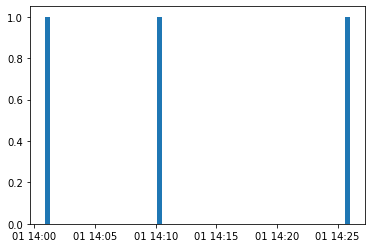

In [49]:
hour_y, hour_bins = get_y_and_bins(64, b827ebc178d2_transformed[hour_mask], projected_45[index], \
                          b827ebc178d2_timestamps_dt_hour, 60, truck_clusters)

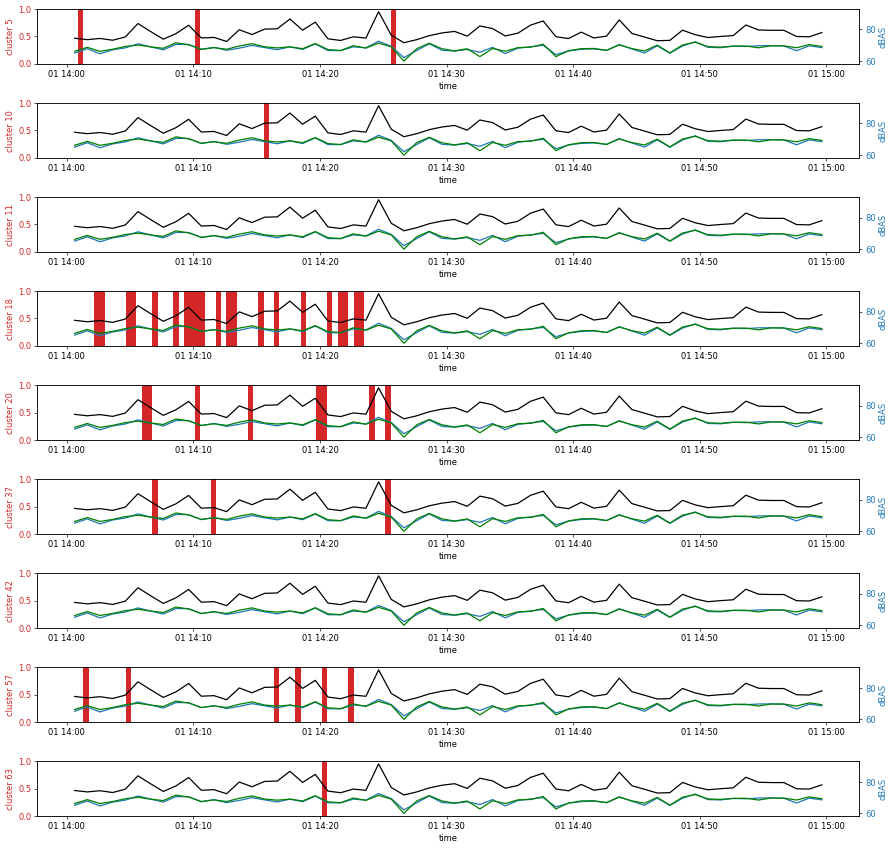

array([737211.750625  , 737211.75091551, 737211.75120602, 737211.75149653,
       737211.75178704, 737211.75207755, 737211.75236806, 737211.75265856,
       737211.75294907, 737211.75323958, 737211.75353009, 737211.7538206 ,
       737211.75411111, 737211.75440162, 737211.75469213, 737211.75498264,
       737211.75527315, 737211.75556366, 737211.75585417, 737211.75614468,
       737211.75643519, 737211.75672569, 737211.7570162 , 737211.75730671,
       737211.75759722, 737211.75788773, 737211.75817824, 737211.75846875,
       737211.75875926, 737211.75904977, 737211.75934028, 737211.75963079,
       737211.7599213 , 737211.76021181, 737211.76050231, 737211.76079282,
       737211.76108333, 737211.76137384, 737211.76166435, 737211.76195486,
       737211.76224537, 737211.76253588, 737211.76282639, 737211.7631169 ,
       737211.76340741, 737211.76369792, 737211.76398843, 737211.76427894,
       737211.76456944, 737211.76485995, 737211.76515046, 737211.76544097,
       737211.76573148, 7

In [53]:
plot_clusters(64, b827ebc178d2_transformed[hour_mask], projected_45[index], \
                          b827ebc178d2_timestamps_dt_hour, minute_time_arr_hour, minute_dBAS_arr_hour, \
                          minute_dBAS_max_hour, minute_dBAS_median_hour, hour_bins, truck_clusters)

# Averaging data over 10 sec

Dataset with one timestamp every 10 seconds

In [54]:
ten_sec_time_arr = np.empty(int(len(time_arr)/10), dtype = datetime.datetime)
ten_sec_dBAS_arr = np.empty(int(len(time_arr)/10))

In [55]:
step = 10
i = 0
count = 0
while i < len(time_arr): 
    ten_sec_time_arr[count] = time_arr[i]
    ten_sec_dBAS_arr[count] = np.average(dBAS_arr[i:i+step])
    i += step
    count += 1

# Taking max of data

In [56]:
ten_sec_dBAS_max = np.empty(int(len(time_arr)/10))

In [57]:
step = 10
i = 0
count = 0
while i < len(time_arr): 
    ten_sec_dBAS_max[count] = np.amax(dBAS_arr[i:i+step])
    i += step
    count += 1

In [58]:
ten_sec_dBAS_max

array([67.42, 72.63, 62.28, ..., 62.57, 66.96, 77.04])

# Taking median of data

In [59]:
ten_sec_dBAS_median = np.empty(int(len(time_arr)/10))

In [60]:
step = 10
i = 0
count = 0
while i < len(time_arr): 
    ten_sec_dBAS_median[count] = np.median(dBAS_arr[i:i+step])
    i += step
    count += 1

In [61]:
ten_sec_dBAS_median

array([63.63 , 65.575, 58.28 , ..., 57.625, 60.695, 65.255])

# Plotting 12 hour intervals for one day

Slicing the SPL data

In [62]:
naive_ten_sec_time_arr = [x.replace(tzinfo=None) for x in ten_sec_time_arr]

Slicing for 8am to 8pm

In [63]:
naive_ten_sec_time_arr_np = np.array(naive_ten_sec_time_arr)
ten_sec_time_arr_am_mask = \
get_time_mask(datetime.datetime(2019, 6, 1, 8), datetime.datetime(2019, 6, 1, 20), naive_ten_sec_time_arr_np)

In [64]:
ten_sec_time_arr_am = ten_sec_time_arr[ten_sec_time_arr_am_mask]
ten_sec_dBAS_arr_am = ten_sec_dBAS_arr[ten_sec_time_arr_am_mask]
ten_sec_dBAS_max_am = ten_sec_dBAS_max[ten_sec_time_arr_am_mask]
ten_sec_dBAS_median_am = ten_sec_dBAS_median[ten_sec_time_arr_am_mask]

Slicing for 8pm to 8am

In [65]:
ten_sec_time_arr_pm_mask = \
get_time_mask(datetime.datetime(2019, 6, 1, 20), datetime.datetime(2019, 6, 2, 8), naive_ten_sec_time_arr_np)

In [66]:
ten_sec_time_arr_pm = ten_sec_time_arr[ten_sec_time_arr_pm_mask]
ten_sec_dBAS_arr_pm = ten_sec_dBAS_arr[ten_sec_time_arr_pm_mask]
ten_sec_dBAS_max_pm = ten_sec_dBAS_max[ten_sec_time_arr_pm_mask]
ten_sec_dBAS_median_pm = ten_sec_dBAS_median[ten_sec_time_arr_pm_mask]

# Plotting 1 hour intervals

Slicing the SPL data

Slicing for 2pm to 3pm

In [67]:
ten_sec_time_arr_hour_mask = \
get_time_mask(datetime.datetime(2019, 6, 1, 14), datetime.datetime(2019, 6, 1, 15), naive_ten_sec_time_arr_np)

In [68]:
ten_sec_time_arr_hour = ten_sec_time_arr[ten_sec_time_arr_hour_mask]
ten_sec_dBAS_arr_hour = ten_sec_dBAS_arr[ten_sec_time_arr_hour_mask]
ten_sec_dBAS_max_hour = ten_sec_dBAS_max[ten_sec_time_arr_hour_mask]
ten_sec_dBAS_median_hour = ten_sec_dBAS_median[ten_sec_time_arr_hour_mask]

In [69]:
# ten_sec_hour_bins = plot_clusters(64, b827ebc178d2_transformed[hour_mask], projected_45[index], \
#                           b827ebc178d2_timestamps_dt_hour, ten_sec_time_arr_hour, ten_sec_dBAS_arr_hour, \
#                           ten_sec_dBAS_max_hour, ten_sec_dBAS_median_hour, 600, truck_clusters)

In [70]:
# plot_truck_clusters(64, b827ebc178d2_transformed[hour_mask], projected_45[index], \
#                           b827ebc178d2_timestamps_dt_hour, ten_sec_time_arr_hour, ten_sec_dBAS_arr_hour, \
#                           ten_sec_dBAS_max_hour, ten_sec_dBAS_median_hour, ten_sec_hour_bins, truck_clusters)

# Dataframe with timestamps and cluster assignment

Dataframe spanning over the whole month


In [76]:
all_cluster_assignments = get_cluster_assignments(64, b827ebc178d2_transformed, projected_45[index])
seconds_b827ebc178d2_timestamps_dt = [x.replace(microsecond=0) for x in b827ebc178d2_timestamps_dt]

In [77]:
assignments_df = pd.DataFrame(data={'assignment':all_cluster_assignments}, \
                              index = seconds_b827ebc178d2_timestamps_dt)
assignments_df.head()

,assignment
2019-06-01 00:00:16-04:00,59
2019-06-01 00:00:17-04:00,33
2019-06-01 00:00:18-04:00,36
2019-06-01 00:00:19-04:00,9
2019-06-01 00:00:20-04:00,36


Removed all duplicate entries in dataframe

In [78]:
removed_assignments_df = assignments_df[~assignments_df.index.duplicated()]

In [79]:
complete = pd.date_range(datetime.datetime(2019, 6, 1, 4), datetime.datetime(2019, 7, 1, 4), periods=3600*24*30)
seconds_complete = [x.replace(microsecond=0, nanosecond=0) for x in complete]
aware_seconds_complete = [pytz.utc.localize(x) for x in seconds_complete]
tz_seconds_complete = [x.astimezone(pytz.timezone('US/Eastern')) for x in aware_seconds_complete]

Replaces actual cluster assignment with 0 for no assignment value, 1 for a truck cluster, 2 for every other cluster

In [80]:
complete_assignments_df = removed_assignments_df.reindex(tz_seconds_complete, axis='index', fill_value = 0)

In [81]:
complete_assignments_df = complete_assignments_df.replace(truck_clusters, 1)
complete_assignments_df = complete_assignments_df.replace(range(2,64), 2)

In [82]:
complete_assignments_df.head()

,assignment
2019-06-01 00:00:00-04:00,0
2019-06-01 00:00:01-04:00,0
2019-06-01 00:00:02-04:00,0
2019-06-01 00:00:03-04:00,0
2019-06-01 00:00:04-04:00,0


In [83]:
complete_assignments_df.tail()

,assignment
2019-06-30 23:59:55-04:00,2
2019-06-30 23:59:56-04:00,0
2019-06-30 23:59:57-04:00,0
2019-06-30 23:59:58-04:00,0
2019-07-01 00:00:00-04:00,0


# Dataframe with timestamp and SPL value

In [84]:
time_df.head()

,timestamp,dBAS
0,2019-06-01 00:00:42.690000-04:00,63.53
1,2019-06-01 00:00:43.690000-04:00,63.73
2,2019-06-01 00:00:44.690000-04:00,64.94
3,2019-06-01 00:00:45.690000-04:00,63.09
4,2019-06-01 00:00:46.690000-04:00,61.66


In [85]:
naive_time_df = [x.replace(tzinfo=None) for x in time_df['timestamp']]

In [86]:
complete_hour_mask = get_time_mask(datetime.datetime(2019, 6, 1, 14), \
                                   datetime.datetime(2019, 6, 1, 15), np.asarray(naive_time_df))

In [87]:
seconds_complete_hour_timestamp = [x.replace(microsecond=0) for x in time_df['timestamp'][complete_hour_mask]]

In [88]:
dBAS_hour = np.asarray(time_df['dBAS'][complete_hour_mask])

In [89]:
spl_hour_df = pd.DataFrame(data={'dBAS': dBAS_hour}, index=seconds_complete_hour_timestamp)

In [90]:
spl_hour_df.tail()

,dBAS
2019-06-01 14:59:55-04:00,63.58
2019-06-01 14:59:56-04:00,65.32
2019-06-01 14:59:57-04:00,67.63
2019-06-01 14:59:58-04:00,69.10
2019-06-01 14:59:59-04:00,71.14


Complete SPL dataframe

In [91]:
seconds_complete_timestamp = [x.replace(microsecond=0) for x in time_df['timestamp']]

In [92]:
spl_df = pd.DataFrame(data={'dBAS': dBAS_arr}, index=seconds_complete_timestamp)

In [93]:
spl_df.tail()

,dBAS
2019-07-01 00:00:38-04:00,66.04
2019-07-01 00:00:39-04:00,69.75
2019-07-01 00:00:40-04:00,68.68
2019-07-01 00:00:41-04:00,73.17
2019-07-01 00:00:42-04:00,77.04


# Joining cluster assignment dataframe and SPL dataframe

This dataframe is for the whole month, so if you slice it based on date, it will give you different subsets of information. There is no need to recreate any dataframes.

In [94]:
all_joined_df = spl_df.join(complete_assignments_df)

In [95]:
all_joined_df.loc[pd.isnull(all_joined_df['assignment']), 'assignment'] = 0

Gets rid of the extra 42 seconds of data in July 1st

In [96]:
all_joined_df_cut = all_joined_df[:-42]

In [97]:
all_joined_df_cut.head()

,dBAS,assignment
2019-06-01 00:00:42-04:00,63.53,2.0
2019-06-01 00:00:43-04:00,63.73,2.0
2019-06-01 00:00:44-04:00,64.94,2.0
2019-06-01 00:00:45-04:00,63.09,2.0
2019-06-01 00:00:46-04:00,61.66,2.0


In [101]:
am_joined_df = all_joined_df_cut['2019-06-01 08:00:00-04:00':'2019-06-01 20:00:00-04:00']

In [102]:
am_joined_df.tail()

,dBAS,assignment
2019-06-01 19:59:56-04:00,65.82,2.0
2019-06-01 19:59:57-04:00,62.40,2.0
2019-06-01 19:59:58-04:00,63.28,2.0
2019-06-01 19:59:59-04:00,62.96,2.0
2019-06-01 20:00:00-04:00,63.38,0.0


In [103]:
import scipy.signal
import scipy.ndimage

# Plotting truck activity and SPL

In [105]:
def plot_truck_clusters(joined_df, peak_window_size, smoothing_window_size, ds_factor, smoothing):
    """
    Plots the SPL over time with visual cues indicating the presence of trucks over time for one sensor.
    
    Parameters
    ----------
    joined_df : dataframe
        A dataframe containing timestamps, a column for cluster assignments, and dBAS values.
    
    peak_window_size : int
        Parameter for peak picking
        
    ds_factor : int
        Downsample factor for getting the median
        
    smoothing : String
        Smoothing type, e.g. mean, median, or gaussian.
    """
    y_vals = []
    joined_df_reset_index = joined_df.reset_index()
    
    #Peaks for all SPL values
    window = int((peak_window_size-1)/2)
    spl_peaks = librosa.util.peak_pick(joined_df['dBAS'], window, window, window, window, 3, 0)
    spl_peaks_arr = joined_df_reset_index.loc[spl_peaks]
    dBAS_peaks = joined_df['dBAS'][spl_peaks]
    timestamp_peaks = joined_df_reset_index['index'][spl_peaks]
   
    truck_timestamp_peaks = spl_peaks_arr['index'].loc[spl_peaks_arr['assignment']==1]
    print(truck_timestamp_peaks)
    truck_dBAS_peaks = spl_peaks_arr['dBAS'].loc[spl_peaks_arr['assignment']==1]
    print(truck_dBAS_peaks)
    
    
    #Peaks for SPL values corresponding to other clusters
    other_dBAS_peaks = spl_peaks_arr.loc[spl_peaks_arr['assignment']==2]['dBAS']
    other_timestamp_peaks = spl_peaks_arr.loc[spl_peaks_arr['assignment']==2]['index']
    
    fig, ax1 = plt.subplots()  
    color = 'b'
    
    ax1.set_xlabel('time')
    ax1.set_ylabel('SPL', color=color)
        
    #Plot all SPL peaks
    #Plot dot over max SPL value when that value corresponds to a trucking instance
    ax1.scatter(truck_timestamp_peaks, truck_dBAS_peaks, color='r', s=20)
    ax1.tick_params(axis='y', labelcolor=color)
    
    #Plot SPL peaks corresponding to other clusters
    ax1.scatter(other_timestamp_peaks, other_dBAS_peaks, color='tab:gray', s=20)
    ax1.set_xlim([joined_df_reset_index['index'].iloc[0], joined_df_reset_index['index'].iloc[-1]])
    
    if smoothing == 'median':
        medfit = scipy.signal.medfilt(joined_df['dBAS'].values, smoothing_window_size)[::ds_factor]
        ax1.plot(joined_df.iloc[::ds_factor].reset_index()['index'], medfit, color='g')
        max_y = medfit
    elif smoothing == 'mean':
        mean_filter = scipy.ndimage.convolve(joined_df['dBAS'].values, 
                                             np.ones(smoothing_window_size) / smoothing_window_size)[::ds_factor]
        ax1.plot(joined_df.iloc[::ds_factor].reset_index()['index'], mean_filter, color='g')
        max_y = mean_filter        
    elif smoothing == 'gaussian':
        gaussian_filter = scipy.ndimage.filters.gaussian_filter(joined_df['dBAS'].values, smoothing_window_size)[::ds_factor]
        ax1.plot(joined_df.iloc[::ds_factor].reset_index()['index'], gaussian_filter, color='g')
        max_y = gaussian_filter
    else:
        raise Exception('Unknown smoothing type')
    
    print(len(joined_df.iloc[::ds_factor]))
    #Plot regions corresponding to trucks
    ax1.fill_between(x=joined_df.iloc[::ds_factor].reset_index()['index'], \
                     y1=len(joined_df.iloc[::ds_factor]['dBAS'])*[joined_df['dBAS'].min()], \
                     y2=max_y, \
                     where=joined_df.iloc[::ds_factor].reset_index()['assignment']==1, \
                     color='r', alpha=0.5)
    
    #Plot regions corresponding to other clusters
    ax1.fill_between(x=joined_df.iloc[::ds_factor].reset_index()['index'], \
                     y1=len(joined_df.iloc[::ds_factor]['dBAS'])*[joined_df['dBAS'].min()], \
                     y2=max_y, where=joined_df.iloc[::ds_factor].reset_index()['assignment']==2, \
                     color='tab:gray', alpha=0.5)
    
    ax1.set_ylim(joined_df['dBAS'].min())
    fig.set_size_inches(18.5, 10.5)
    fig.tight_layout()
    fig.show()

In [106]:
# plot_truck_clusters(hour_joined_df, hour_joined_df.index[0], hour_joined_df.index[-1], 7, 11, 1, 'gaussian')

In [107]:
# all_joined_df_cut['2019-06-03 14:00:00-04:00':'2019-06-03 14:30:00-04:00'].iloc[::15].reset_index()['index']

/home/cusp/meh708/.conda/envs/redhook_analysis_storage/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


594    2019-06-03 14:09:54-04:00
913    2019-06-03 14:15:13-04:00
956    2019-06-03 14:15:56-04:00
1068   2019-06-03 14:17:48-04:00
1740   2019-06-03 14:29:00-04:00
Name: index, dtype: datetime64[ns, US/Eastern]
594     75.07
913     73.52
956     75.84
1068    77.20
1740    82.17
Name: dBAS, dtype: float64
121


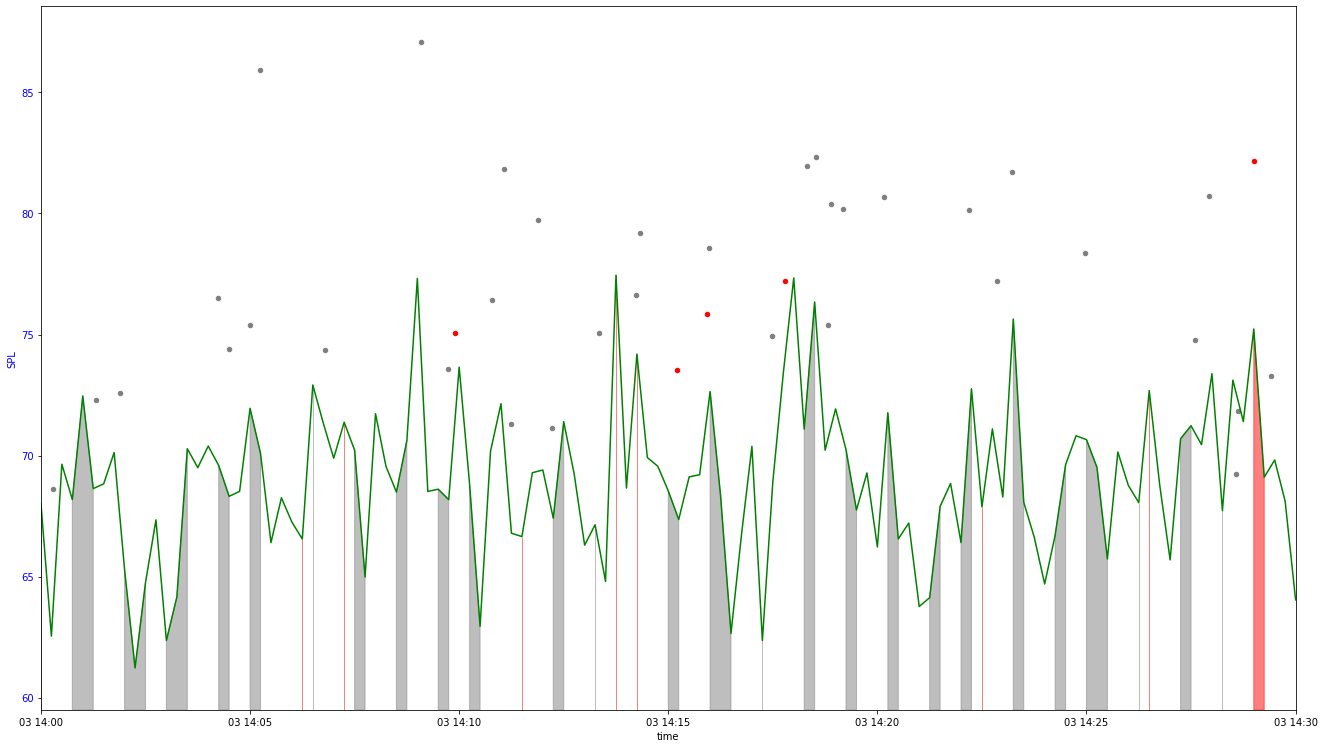

In [108]:
plot_truck_clusters(all_joined_df_cut['2019-06-03 14:00:00-04:00':'2019-06-03 14:30:00-04:00'], \
                            7, 11, 15, 'mean')

In [109]:
# plot_truck_clusters(all_joined_df_cut['2019-06-03 14:40:00-04:00':'2019-06-03 14:50:00-04:00'], \
#                             7, 0.5, 1, 'gaussian')

# Creating matrix of SPL values over each day

Matrix of time and day, containing SPL values for every second of every day (only weekdays)

In [110]:
spl_complete = spl_df['dBAS']

In [111]:
beginning_spl_indices = \
pd.date_range(datetime.datetime(2019, 6, 1, 4, 0, 0), datetime.datetime(2019, 6, 1, 4, 0, 42), periods=42)
beginning_spl_indices = [x.replace(microsecond=0, nanosecond=0) for x in beginning_spl_indices]
beginning_spl_indices = [pytz.utc.localize(x) for x in beginning_spl_indices]
beginning_spl_indices = [x.astimezone(pytz.timezone('US/Eastern')) for x in beginning_spl_indices]

In [112]:
beginning_spl = pd.Series(np.nan, index=beginning_spl_indices)

In [113]:
spl_complete_2 = pd.concat([beginning_spl, spl_complete])

In [114]:
spl_complete_month = spl_complete_2[:-43]

Filtering to only include weekday values

In [115]:
spl_complete_month_weekdays = spl_complete_month[spl_complete_month.index.dayofweek < 5]

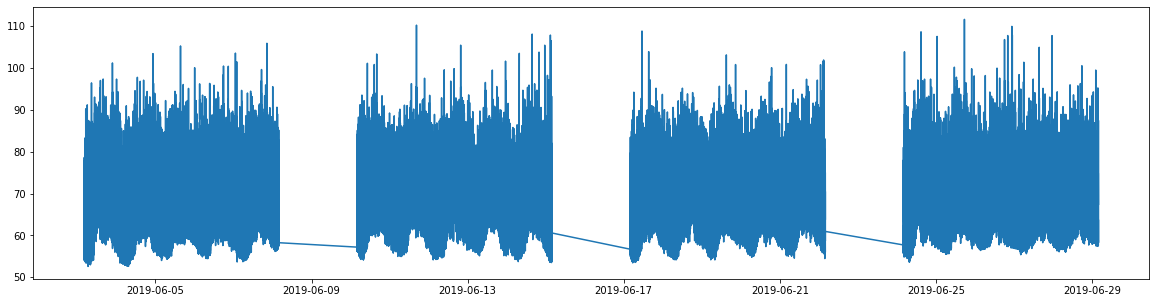

In [116]:
plt.figure(figsize=(20,5))
plt.plot(spl_complete_month_weekdays)
plt.show()

Removing duplicate values

In [117]:
spl_complete_month_weekdays = spl_complete_month_weekdays[~spl_complete_month_weekdays.index.duplicated()]

In [118]:
def get_median(spl_arr):
    """
    Returns an array of median SPL values for each second over every weekday in June. For each second of the day, it 
    takes the median SPL over all weekdays, so that there is a medial SPL value for each second.
    
    Parameters
    ----------
    spl_arr : float array with datetime index
        Array with a datetime index and SPL values corresponding to the index.
    """
    
    #Creates an array of all days in the spl arr
    all_day_arr = []
    print(np.unique(spl_arr.index.day))
    for day in np.unique(spl_arr.index.day):
        day_arr = [x for x in spl_arr.reset_index()['index'] \
                   if x.day==day]
        all_day_arr.append(day_arr)
        print(str(day) + ': ' + str(len(day_arr)))

    #Creates a matrix of each second of the day and all the days in the all_day_arr, in order to get the median across
    #the days
    day_time_matrix = np.ndarray((86400,len(all_day_arr)))
    for i,day in enumerate(all_day_arr):
        complete_day_arr = np.zeros(86400)
        for time in day:
            num_secs_since_beginning = 3600*time.hour + 60*time.minute + time.second
            complete_day_arr[num_secs_since_beginning] = \
            spl_arr.loc[time]
        #changes zeros to NaN values for the purposes of getting a median
        complete_day_arr[complete_day_arr<1] = np.nan

        day_time_matrix[:,i] = complete_day_arr
    
    median_arr = np.nanmedian(day_time_matrix, axis=1)
    
    return median_arr

# Creating median array for weekends

In [119]:
spl_complete_month_weekends = spl_complete_month[spl_complete_month.index.dayofweek >= 5]

In [120]:
spl_complete_month_weekends = spl_complete_month_weekends[~spl_complete_month_weekends.index.duplicated()]

In [121]:
weekend_medians = get_median(spl_complete_month_weekends)

[ 1  2  8  9 15 16 22 23 29 30]
1: 86337
2: 86338
8: 86335
9: 86201
15: 86335
16: 86338
22: 86335
23: 86244
29: 86335
30: 86340


/home/cusp/meh708/.conda/envs/redhook_analysis_storage/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in less


In [122]:
weekend_medians

array([61.01, 63.16, 64.48, ..., 59.1 , 59.  , 59.37])

In [123]:
weekday_medians = get_median(spl_complete_month_weekdays)

[ 3  4  5  6  7 10 11 12 13 14 17 18 19 20 21 24 25 26 27 28]
3: 86340
4: 86338
5: 86339
6: 86333
7: 86341
10: 86361
11: 86337
12: 86325
13: 86349
14: 86338
17: 86338
18: 86337
19: 86339
20: 86341
21: 86336
24: 86316
25: 86338
26: 86087
27: 86218
28: 86356


In [124]:
weekday_medians

array([57.755, 58.22 , 57.98 , ..., 58.86 , 58.805, 59.135])

In [125]:
2589898 % len(weekday_medians)

84298

In [129]:
len(scipy.ndimage.gaussian_filter1d(weekday_medians, 1000))

86400

First 42 seconds of June that somehow didn't get included in the measured SPL data

In [133]:
beginning_spl_indices_series = pd.Series(data=beginning_spl_indices)

Creating datetime indices spanning the whole month, with the additional 42 secs in the beginning of June

In [134]:
medians_df_index = pd.concat([beginning_spl_indices_series[0:42], all_joined_df.reset_index()['index']])

In [135]:
month_weekday_median = np.empty(len(medians_df_index))

In [136]:
for i in range(len(medians_df_index)):
    month_weekday_median[i] = weekday_medians[i%len(weekday_medians)]

In [137]:
month_weekday_median

array([57.755, 58.22 , 57.98 , ..., 62.44 , 60.525, 62.255])

In [138]:
weekday_medians_df = pd.DataFrame({'median_dBAS':month_weekday_median}, index=medians_df_index)

In [139]:
weekday_medians_df.tail()

,median_dBAS
2019-07-01 00:00:38-04:00,61.100
2019-07-01 00:00:39-04:00,61.420
2019-07-01 00:00:40-04:00,62.440
2019-07-01 00:00:41-04:00,60.525
2019-07-01 00:00:42-04:00,62.255


In [140]:
# plt.figure(figsize=(20,5))
# # plt.plot(spl_complete_month_weekdays)
# #plt.plot(scipy.ndimage.convolve(weekday_medians, np.ones(1001)/1001))
# plt.plot(weekday_medians_df.reset_index()['index'], \
#          scipy.ndimage.gaussian_filter1d(weekday_medians_df['median_dBAS'], 1000))
# plt.show()

# Creating dataframe with weekday medians for whole month

In [141]:
weekend_medians_df_indices = weekday_medians_df.loc[weekday_medians_df.index.dayofweek>=5].index

In [142]:
weekend_medians_df_values = np.empty(len(weekend_medians_df_indices))

Replacing weekday values in weekend times with the weekend median SPL

In [143]:
for x in range(len(weekend_medians_df_values)):
    weekend_medians_df_values[x] = weekend_medians[x % len(weekend_medians)]

In [144]:
weekend_medians_df_values

array([61.01, 63.16, 64.48, ..., 59.41, 58.84, 58.08])

Making a dataframe with weekend medians

In [145]:
weekend_medians_df = pd.DataFrame({'median_dBAS':weekend_medians_df_values}, index=weekend_medians_df_indices)

In [146]:
weekend_medians_df = weekend_medians_df[~weekend_medians_df.index.duplicated()]

In [167]:
weekend_medians_df.tail()

,median_dBAS
2019-06-30 23:59:55-04:00,58.480
2019-06-30 23:59:56-04:00,59.075
2019-06-30 23:59:57-04:00,59.410
2019-06-30 23:59:58-04:00,58.840
2019-06-30 23:59:59-04:00,58.080


# Replacing weekend values in dataframe with correct values

Merging dataframe with weekday median values and dataframe with weekend median values. The dataframe with weekday median values has indices for the whole month. Indices that are on the weekend will be replaced with the weekend median values.

In [148]:
both_medians_df = weekday_medians_df.merge(weekend_medians_df, how='outer', left_index=True, right_index=True)

median_dBAS_x is the weekday median values, median_dBAS_y is the weekend median values. Since this is an outer join, many values in median_dBAS_y will be NaN.

In [149]:
both_medians_df.head()

,median_dBAS_x,median_dBAS_y
2019-06-01 00:00:00-04:00,57.755,61.01
2019-06-01 00:00:01-04:00,58.220,63.16
2019-06-01 00:00:02-04:00,57.980,64.48
2019-06-01 00:00:03-04:00,58.360,63.70
2019-06-01 00:00:04-04:00,58.730,63.76


Creates a new column that replaces weekday median values that are in the weekend index with the weekend median values.

In [150]:
both_medians_df['median_dBAS'] = \
both_medians_df['median_dBAS_x'].where(both_medians_df['median_dBAS_y'].isnull(), \
                                                                              both_medians_df['median_dBAS_y'])

Example: 

In [151]:
both_medians_df.loc['2019-06-28 23:00:33-04:00']

median_dBAS_x    67.365
median_dBAS_y       NaN
median_dBAS      67.365
Name: 2019-06-28 23:00:33-04:00, dtype: float64

Gets rid of the columns with weekday and weekend median values, since we have a column with the correct median values for both weekdays and weekends.

In [152]:
both_medians_df = both_medians_df.drop(['median_dBAS_x', 'median_dBAS_y'], axis=1)

In [153]:
both_medians_df.head()

,median_dBAS
2019-06-01 00:00:00-04:00,61.01
2019-06-01 00:00:01-04:00,63.16
2019-06-01 00:00:02-04:00,64.48
2019-06-01 00:00:03-04:00,63.70
2019-06-01 00:00:04-04:00,63.76


# Creating dataframe with weekday medians for whole month

Plot of weekday median SPL over one day

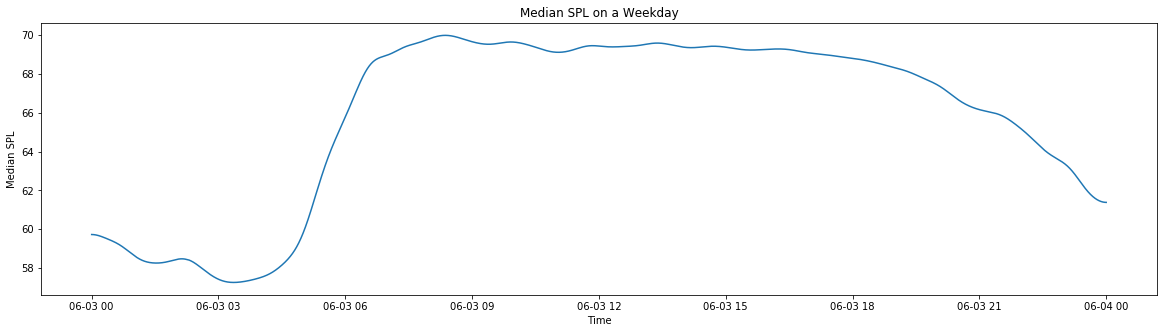

<Figure size 432x288 with 0 Axes>

In [176]:
plt.figure(figsize=(20,5))
# plt.plot(spl_complete_month_weekdays)
#plt.plot(scipy.ndimage.convolve(weekday_medians, np.ones(1001)/1001))
plt.plot(both_medians_df['2019-06-03 00:00:00-04:00':'2019-06-04 00:00:00-04:00'].reset_index()['index'], \
         scipy.ndimage.gaussian_filter1d(both_medians_df['median_dBAS']['2019-06-03 00:00:00-04:00':'2019-06-04 00:00:00-04:00'], 1000))
plt.title('Median SPL on a Weekday')
plt.xlabel('Time')
plt.ylabel('Median SPL')
plt.show()
# plt.savefig('median_weekday_spl.png')

Plot of weekend median SPL over one day

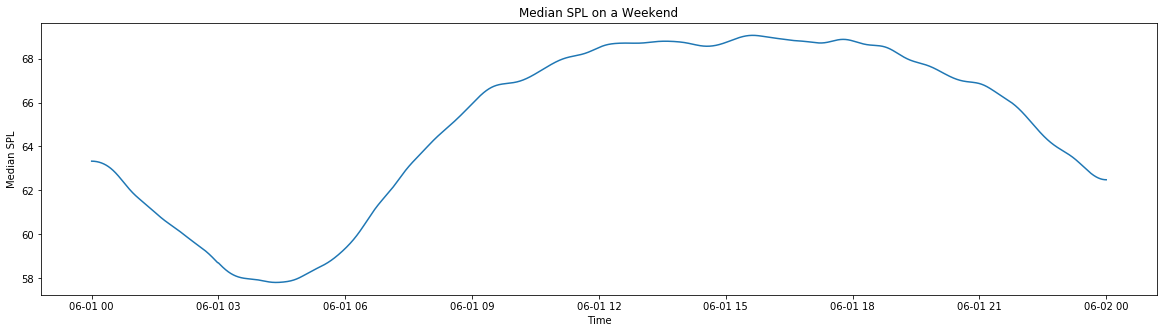

In [179]:
plt.figure(figsize=(20,5))
# plt.plot(spl_complete_month_weekdays)
#plt.plot(scipy.ndimage.convolve(weekday_medians, np.ones(1001)/1001))
plt.plot(both_medians_df['2019-06-01 00:00:00-04:00':'2019-06-02 00:00:00-04:00'].reset_index()['index'], \
         scipy.ndimage.gaussian_filter1d(both_medians_df['median_dBAS']['2019-06-01 00:00:00-04:00':'2019-06-02 00:00:00-04:00'], 1000))
plt.title('Median SPL on a Weekend')
plt.xlabel('Time')
plt.ylabel('Median SPL')
plt.show()
# plt.savefig('median_weekend_spl.png')

# Joining weekday and weekend medians to dataframe

Joining the median dataframe to the dataframe with SPL and cluster assignment

In [180]:
all_joined_df_cut_median = all_joined_df_cut.join(both_medians_df)

In [181]:
all_joined_df_cut_median.loc['2019-06-29 23:00:33-04:00']

,dBAS,assignment,median_dBAS
2019-06-29 23:00:33-04:00,65.27,2.0,61.59
2019-06-29 23:00:33-04:00,65.27,2.0,61.59
2019-06-29 23:00:33-04:00,71.26,2.0,61.59
2019-06-29 23:00:33-04:00,71.26,2.0,61.59


Removing duplicate values

In [182]:
removed_all_joined_df_cut_median = all_joined_df_cut_median[~all_joined_df_cut_median.index.duplicated()]

In [183]:
def plot_truck_clusters_median(joined_df_median, peak_window_size, \
                                       smoothing_window_size, smoothing_window_size_ambient, ds_factor, smoothing):
    """
    Plots the SPL over time with visual cues indicating the presence of trucks over time for one sensor. The shaded
    regions indicate time when sound was recorded (versuss just SPL, which is constantly recorded). There is only
    shading when the SPL recorded at the time is greater than the median SPL. 
    SPL peaks corresponding to truck activity are plotted with red dots. SPL peaks corresponding to other noises are 
    plotted with gray dots. The median SPL is plotted in blue. The SPL is plotted in green. The recorded sound 
    corresponding to trucks is plotted in red. The recorded sound corresponding to anything other than a truck is 
    plotted in light gray.
    
    Parameters
    ----------
    joined_df : dataframe
        A dataframe containing timestamps, a column for cluster assignments, and dBAS values.
    
    peak_window_size : int
        Parameter for peak picking. Cannot be lower than 3.
        
    smoothing_window : float
        Parameter for smoothing the current SPL. Increasing it smoothes the curve more.
        
    smoothing_window_size_ambient : int
        Parameter for smoothing the ambient SPL. Increasing it smoothes the curve more.
        
    ds_factor : int
        Downsample factor for getting the median
        
    'smoothing' : String
        Type of smoothing. Either median, mean, or gaussian.
    """
    y_vals = []
    joined_df_reset_index = joined_df_median.reset_index()

    #Peaks for all SPL values
    window = int((peak_window_size-1)/2)
    spl_peaks = librosa.util.peak_pick(joined_df_median['dBAS'], window, window, window, window, 3, 0)
    spl_peaks_arr = joined_df_reset_index.loc[spl_peaks]
    dBAS_peaks = joined_df_median['dBAS'][spl_peaks]
    timestamp_peaks = joined_df_reset_index['index'][spl_peaks]
   
    truck_timestamp_peaks = spl_peaks_arr['index'].loc[spl_peaks_arr['assignment']==1]
    truck_dBAS_peaks = spl_peaks_arr['dBAS'].loc[spl_peaks_arr['assignment']==1]
    
    #Peaks for SPL values corresponding to other clusters
    other_dBAS_peaks = spl_peaks_arr.loc[spl_peaks_arr['assignment']==2]['dBAS']
    other_timestamp_peaks = spl_peaks_arr.loc[spl_peaks_arr['assignment']==2]['index']
    
    fig, ax1 = plt.subplots()  
    color = 'b'
    
    ax1.set_xlabel('time')
    ax1.set_ylabel('SPL', color=color)
        
    #Plot dot over max SPL value when that value corresponds to a trucking instance
    ax1.scatter(truck_timestamp_peaks, truck_dBAS_peaks, color='r', s=20)
    ax1.tick_params(axis='y', labelcolor=color)
    
    #Plot SPL peaks corresponding to other clusters
    ax1.scatter(other_timestamp_peaks, other_dBAS_peaks, color='tab:gray', s=20)
    ax1.set_xlim([joined_df_reset_index['index'].iloc[0], joined_df_reset_index['index'].iloc[-1]])
    
    if smoothing == 'median':
        plot_y = scipy.signal.medfilt(joined_df_median['dBAS'].values, smoothing_window_size)[::ds_factor]
        plot_y_median = scipy.signal.medfilt(joined_df_median['median_dBAS'].values, \
                                             smoothing_window_size_ambient)[::ds_factor]
    elif smoothing == 'mean':
        plot_y = scipy.ndimage.convolve(joined_df_median['dBAS'].values, 
                                             np.ones(smoothing_window_size) / smoothing_window_size)[::ds_factor]
        plot_y_median = scipy.ndimage.convolve(joined_df_median['median_dBAS'].values, \
                                                    np.ones(smoothing_window_size_ambient) / smoothing_window_size_ambient)[::ds_factor]
    elif smoothing == 'gaussian':
        plot_y = scipy.ndimage.filters.gaussian_filter(joined_df_median['dBAS'].values, \
                                                                smoothing_window_size)[::ds_factor]
        plot_y_median = scipy.ndimage.filters.gaussian_filter(joined_df_median['median_dBAS'].values, \
                                                                smoothing_window_size_ambient)[::ds_factor]
    else:
        raise Exception('Unknown smoothing type')
        
    #Plot SPL and median SPL
    ax1.plot(joined_df_median.iloc[::ds_factor].reset_index()['index'], plot_y, color='g')
    ax1.plot(joined_df_median.iloc[::ds_factor].reset_index()['index'], plot_y_median, color='b')
    
    #Shade regions of sound that correspond to trucks according to cluster assignment
    ax1.fill_between(x=joined_df_median.iloc[::ds_factor].reset_index()['index'], \
                     y1=len(joined_df_median.iloc[::ds_factor]['dBAS'])*[joined_df_median['dBAS'].min()], \
                     y2=plot_y, \
                     where=joined_df_median.iloc[::ds_factor]['assignment']==1, \
                     color='r', alpha=0.5)
    
    #Plot regions corresponding to other clusters
    ax1.fill_between(x=joined_df_median.iloc[::ds_factor].reset_index()['index'], \
                     y1=len(joined_df_median.iloc[::ds_factor]['dBAS'])*[joined_df_median['dBAS'].min()], \
                     y2=plot_y, where=joined_df_median.iloc[::ds_factor]['assignment']==2, \
                     color='tab:gray', alpha=0.5)
    
    ax1.set_ylim(joined_df_median['dBAS'].min())
    fig.set_size_inches(18.5, 10.5)
    fig.tight_layout()
    fig.show()

/home/cusp/meh708/.conda/envs/redhook_analysis_storage/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


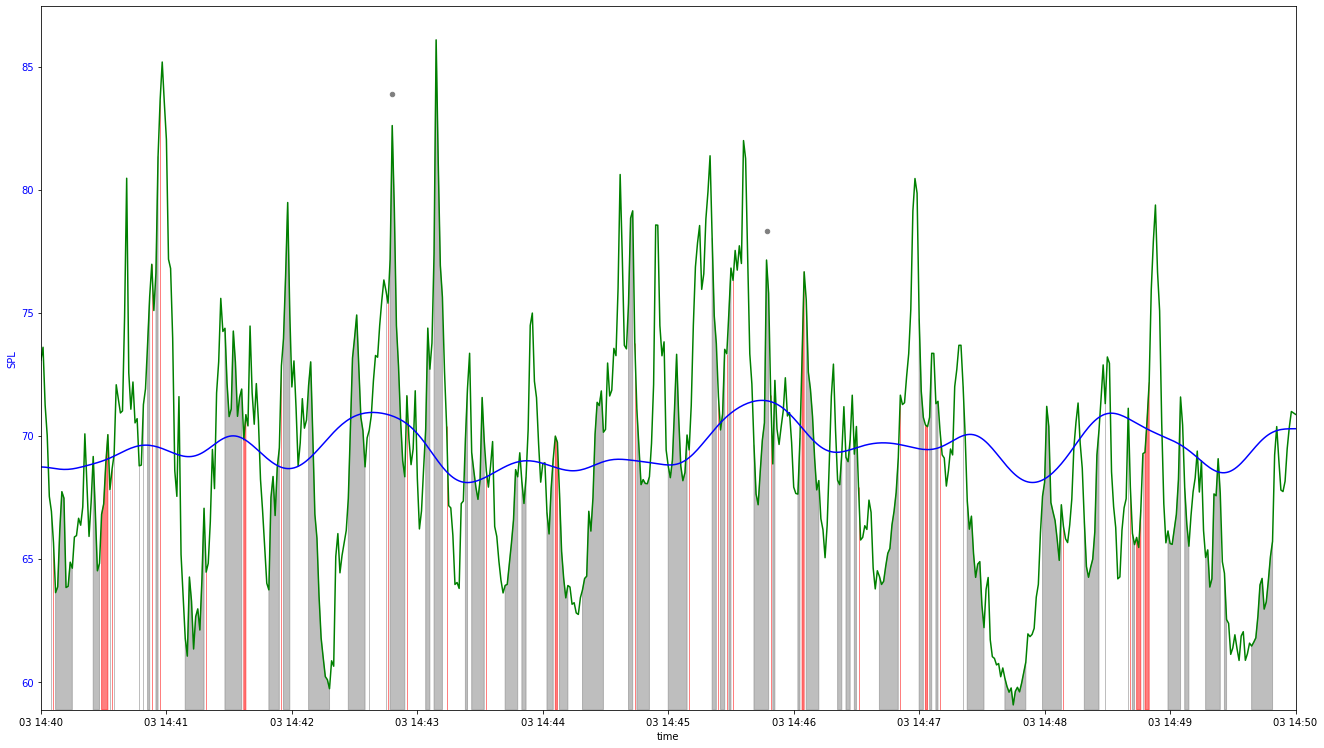

In [184]:
plot_truck_clusters_median(all_joined_df_cut_median['2019-06-03 14:40:00-04:00':'2019-06-03 14:50:00-04:00'], \
                            3, 0.5, 10, 1, 'gaussian')

In [185]:
def plot_truck_clusters_median_shading(joined_df_median, peak_window_size, \
                                       smoothing_window_size, smoothing_window_size_ambient, ds_factor, smoothing):
    """
    Plots the SPL over time with visual cues indicating the presence of trucks over time for one sensor. The shaded
    regions indicate time when sound was recorded (versuss just SPL, which is constantly recorded). There is only
    shading when the SPL recorded at the time is greater than the median SPL. 
    SPL peaks corresponding to truck activity are plotted with red dots. SPL peaks corresponding to other noises are 
    plotted with gray dots. The median SPL is plotted in blue. The SPL is plotted in green. The recorded sound 
    corresponding to trucks is plotted in red. The recorded sound corresponding to anything other than a truck is 
    plotted in light gray.
    
    Parameters
    ----------
    joined_df : dataframe
        A dataframe containing timestamps, a column for cluster assignments, and dBAS values.
    
    peak_window_size : int
        Parameter for peak picking. Cannot be lower than 3.
        
    smoothing_window : float
        Parameter for smoothing the current SPL. Increasing it smoothes the curve more.
        
    smoothing_window_size_ambient : int
        Parameter for smoothing the ambient SPL. Increasing it smoothes the curve more.
        
    ds_factor : int
        Downsample factor for getting the median.
        
    'smoothing' : String
        Type of smoothing. Either median, mean, or gaussian.
    """
    y_vals = []
    joined_df_reset_index = joined_df_median.reset_index()

    #Peaks for all SPL values
    window = int((peak_window_size-1)/2)
    spl_peaks = librosa.util.peak_pick(joined_df_median['dBAS'], window, window, window, window, 3, 0)
    spl_peaks_arr = joined_df_reset_index.loc[spl_peaks]
    dBAS_peaks = joined_df_median['dBAS'][spl_peaks]
    timestamp_peaks = joined_df_reset_index['index'][spl_peaks]
   
    truck_timestamp_peaks = spl_peaks_arr['index'].loc[spl_peaks_arr['assignment']==1]
    truck_dBAS_peaks = spl_peaks_arr['dBAS'].loc[spl_peaks_arr['assignment']==1] 
    
    #Peaks for SPL values corresponding to other clusters
    other_dBAS_peaks = spl_peaks_arr.loc[spl_peaks_arr['assignment']==2]['dBAS']
    other_timestamp_peaks = spl_peaks_arr.loc[spl_peaks_arr['assignment']==2]['index']
    
    fig, ax1 = plt.subplots()  
    color = 'b'
    
    ax1.set_xlabel('time')
    ax1.set_ylabel('SPL', color=color)
        
    #Plot dot over max SPL value when that value corresponds to a trucking instance
    ax1.scatter(truck_timestamp_peaks, truck_dBAS_peaks, color='r', s=20)
    ax1.tick_params(axis='y', labelcolor=color)
    
    #Plot SPL peaks corresponding to other clusters
    ax1.scatter(other_timestamp_peaks, other_dBAS_peaks, color='tab:gray', s=20)
    ax1.set_xlim([joined_df_reset_index['index'].iloc[0], joined_df_reset_index['index'].iloc[-1]])
    
    if smoothing == 'median':
        plot_y = scipy.signal.medfilt(joined_df_median['dBAS'].values, smoothing_window_size)[::ds_factor]
        plot_y_median = scipy.signal.medfilt(joined_df_median['median_dBAS'].values, \
                                             smoothing_window_size_ambient)[::ds_factor]
    elif smoothing == 'mean':
        plot_y = scipy.ndimage.convolve(joined_df_median['dBAS'].values, 
                                             np.ones(smoothing_window_size) / smoothing_window_size)[::ds_factor]
        plot_y_median = scipy.ndimage.convolve(joined_df_median['median_dBAS'].values, \
                                                    np.ones(smoothing_window_size_ambient) / smoothing_window_size_ambient)[::ds_factor]
    elif smoothing == 'gaussian':
        plot_y = scipy.ndimage.filters.gaussian_filter(joined_df_median['dBAS'].values, \
                                                                smoothing_window_size)[::ds_factor]
        plot_y_median = scipy.ndimage.filters.gaussian_filter(joined_df_median['median_dBAS'].values, \
                                                                smoothing_window_size_ambient)[::ds_factor]
    else:
        raise Exception('Unknown smoothing type')
        
    ax1.plot(joined_df_median.iloc[::ds_factor].reset_index()['index'], plot_y, color='g')
    ax1.plot(joined_df_median.iloc[::ds_factor].reset_index()['index'], plot_y_median, color='b')
    
    #Plot regions corresponding to trucks
    ax1.fill_between( \
                     x=joined_df_median.iloc[::ds_factor].reset_index()['index'], \
                     y1=plot_y_median, \
                     y2=plot_y, \
                     where=(joined_df_median.iloc[::ds_factor]['assignment']==1) & (plot_y>plot_y_median), \
                     color='r', alpha=0.5, interpolate=True)
    
    #Plot regions corresponding to other clusters
    ax1.fill_between(x=joined_df_median.iloc[::ds_factor].reset_index()['index'], \
                     y1=plot_y_median, \
                     y2=plot_y, \
                     where=(joined_df_median.iloc[::ds_factor]['assignment']==2) & (plot_y>plot_y_median), 
                     color='tab:gray', alpha=0.5, interpolate=True)
    
    ax1.set_ylim(joined_df_median['dBAS'].min())
    fig.set_size_inches(18.5, 10.5)
    fig.tight_layout()
    fig.show()

In [186]:
# plot_truck_clusters_median_shading(all_joined_df_cut_median['2019-06-03 14:40:00-04:00':'2019-06-03 14:50:00-04:00'], \
#                             7, 0.5, 10, 2, 'gaussian')

In [187]:
def plot_truck_clusters_median_final(joined_df_median, peak_window_size, \
                                       smoothing_window_size, smoothing_window_size_ambient, ds_factor, smoothing):
    """
    Plots the SPL over time with visual cues indicating the presence of trucks over time for one sensor. The shaded
    regions indicate time when sound was recorded (versuss just SPL, which is constantly recorded). There is only
    shading when the SPL recorded at the time is greater than the median SPL. 
    There are dots indicating SPL peaks that correspond to truck activity, plotted in red. The median SPL is plotted 
    in dark gray. The SPL is plotted in light gray. The recorded sound corresponding to trucks is plotted in red. The
    recorded sound corresponding to anything other than a truck is plotted in light blue.
    
    Parameters
    ----------
    joined_df : dataframe
        A dataframe containing timestamps, a column for cluster assignments, and dBAS values.
    
    peak_window_size : int
        Parameter for peak picking. Cannot be lower than 3.
        
    smoothing_window : float
        Parameter for smoothing the current SPL. Increasing it smoothes the curve more.
        
    smoothing_window_size_ambient : int
        Parameter for smoothing the ambient SPL. Increasing it smoothes the curve more.
        
    ds_factor : int
        Downsample factor for getting the median.
        
    'smoothing' : String
        Type of smoothing. Either median, mean, or gaussian.
    """
    y_vals = []
    joined_df_reset_index = joined_df_median.reset_index()
    
    #Peaks for all SPL values
    window = int((peak_window_size-1)/2)
    spl_peaks = librosa.util.peak_pick(joined_df_median['dBAS'], window, window, window, window, 3, 0)
    spl_peaks_arr = joined_df_reset_index.loc[spl_peaks]
    dBAS_peaks = joined_df_median['dBAS'][spl_peaks]
    timestamp_peaks = joined_df_reset_index['index'][spl_peaks]

    truck_timestamp_peaks = spl_peaks_arr['index'].loc[spl_peaks_arr['assignment']==1]
    truck_dBAS_peaks = spl_peaks_arr['dBAS'].loc[spl_peaks_arr['assignment']==1]
    
    other_dBAS_peaks = spl_peaks_arr.loc[spl_peaks_arr['assignment']==2]['dBAS']
    other_timestamp_peaks = spl_peaks_arr.loc[spl_peaks_arr['assignment']==2]['index']
    
    fig, ax1 = plt.subplots()  
    
    ax1.set_xlabel('Time', fontweight='bold', fontsize=25)
    ax1.set_ylabel('SPL (dB)', fontweight='bold', fontsize=25)
    ax1.set_title('SPL Levels', fontweight='bold', fontsize=30)   
    
    #Plot dot over max SPL value when that value corresponds to a trucking instance
    ax1.scatter(truck_timestamp_peaks, truck_dBAS_peaks, color='r', s=50)
    ax1.tick_params(labelsize=20)
    
#     #Plot SPL peaks corresponding to other clusters
#     ax1.scatter(other_timestamp_peaks, other_dBAS_peaks, color='tab:gray', s=20)
# #     ax1.plot(sliced_joined_df_reset_index['index'], sliced_joined_df['dBAS'])
    ax1.set_xlim([joined_df_reset_index['index'].iloc[0], joined_df_reset_index['index'].iloc[-1]])
    
    if smoothing == 'median':
        plot_y = scipy.signal.medfilt(joined_df_median['dBAS'].values, smoothing_window_size)[::ds_factor]
        plot_y_median = scipy.signal.medfilt(joined_df_median['median_dBAS'].values, \
                                             smoothing_window_size_ambient)[::ds_factor]
    elif smoothing == 'mean':
        plot_y = scipy.ndimage.convolve(joined_df_median['dBAS'].values, 
                                             np.ones(smoothing_window_size) / smoothing_window_size)[::ds_factor]
        plot_y_median = scipy.ndimage.convolve(joined_df_median['median_dBAS'].values, \
                                                    np.ones(smoothing_window_size_ambient) / smoothing_window_size_ambient)[::ds_factor]
    elif smoothing == 'gaussian':
        plot_y = scipy.ndimage.filters.gaussian_filter(joined_df_median['dBAS'].values, \
                                                                smoothing_window_size)[::ds_factor]
        plot_y_median = scipy.ndimage.filters.gaussian_filter(joined_df_median['median_dBAS'].values, \
                                                                smoothing_window_size_ambient)[::ds_factor]
    else:
        raise Exception('Unknown smoothing type')
    
    ax1.plot(joined_df_median.iloc[::ds_factor].reset_index()['index'], \
                 plot_y, color='lightgray', linewidth=3)
    ax1.plot(joined_df_median.iloc[::ds_factor].reset_index()['index'], \
                 plot_y_median, color='dimgray', linewidth=3)
    
#     Plot regions corresponding to other clusters
    other_where = (joined_df_median.iloc[::ds_factor]['assignment']==2) & (plot_y > plot_y_median)
    other_where |= np.roll(other_where, 1)
    ax1.fill_between(x=joined_df_median.iloc[::ds_factor].reset_index()['index'], \
                     y1=plot_y_median, \
                     y2=plot_y, \
                     where=other_where, 
                     color='lightblue', interpolate=False)

    
    #Plot regions corresponding to trucks
    truck_where = (joined_df_median.iloc[::ds_factor]['assignment']==1) & (plot_y > plot_y_median)
    truck_where |= np.roll(truck_where, 1)
    ax1.fill_between(x=joined_df_median.iloc[::ds_factor].reset_index()['index'], \
                     y1=plot_y_median, \
                     y2=plot_y, \
                     where=truck_where, \
                     color='r', interpolate=False)

    ax1.set_ylim(joined_df_median['median_dBAS'].min())
    fig.set_size_inches(18.5, 10.5)
    fig.tight_layout()
    fig.show()

In [188]:
# plot_truck_clusters_median_final\
# (removed_all_joined_df_cut_median['2019-06-03 08:00:00-04:00':'2019-06-03 08:10:00-04:00'], \
#                             7, 10, 10, 1, 'gaussian')

In [189]:
def plot_truck_clusters_normalized(joined_df_median, peak_window_size, \
                                       smoothing_window_size, smoothing_window_size_ambient, ds_factor, smoothing):
    """
    Plots the SPL normalized to the median.
    
    Parameters
    ----------
    joined_df : dataframe
        A dataframe containing timestamps, a column for cluster assignments, and dBAS values.
    
    peak_window_size : int
        Parameter for peak picking. Cannot be lower than 3.
        
    smoothing_window : float
        Parameter for smoothing the current SPL. Increasing it smoothes the curve more.
        
    smoothing_window_size_ambient : int
        Parameter for smoothing the ambient SPL. Increasing it smoothes the curve more.
        
    ds_factor : int
        Downsample factor for getting the median.
        
    'smoothing' : String
        Type of smoothing. Either median, mean, or gaussian.
    """
    y_vals = []
    joined_df_reset_index = joined_df_median.reset_index()
    
    joined_df_difference = joined_df_median['dBAS'] - joined_df_median['median_dBAS']
    for i,x in enumerate(joined_df_difference):
        if x < 0:
            joined_df_difference[i] = 0

    #Peaks for all SPL values
    window = int((peak_window_size-1)/2)
    spl_peaks = librosa.util.peak_pick(joined_df_median['dBAS'], window, window, window, window, 3, 0)
    spl_peaks_arr = joined_df_reset_index.loc[spl_peaks]
    dBAS_peaks = joined_df_median['dBAS'][spl_peaks]
    timestamp_peaks = joined_df_reset_index['index'][spl_peaks]
   
    truck_timestamp_peaks = spl_peaks_arr['index'].loc[spl_peaks_arr['assignment']==1]
    print(truck_timestamp_peaks)
    truck_dBAS_peaks = spl_peaks_arr['dBAS'].loc[spl_peaks_arr['assignment']==1]
    print(truck_dBAS_peaks)
    
    
    #Peaks for SPL values corresponding to other clusters
    other_dBAS_peaks = spl_peaks_arr.loc[spl_peaks_arr['assignment']==2]['dBAS']
    other_timestamp_peaks = spl_peaks_arr.loc[spl_peaks_arr['assignment']==2]['index']
    
    fig, ax1 = plt.subplots()  
    color = 'b'
    
    ax1.set_xlabel('time')
    ax1.set_ylabel('SPL', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xlim([joined_df_reset_index['index'].iloc[0], joined_df_reset_index['index'].iloc[-1]])
    
    if smoothing == 'median':
        plot_y = scipy.signal.medfilt(joined_df_median['dBAS'].values, smoothing_window_size)[::ds_factor]
        plot_y_median = scipy.signal.medfilt(joined_df_median['median_dBAS'].values, \
                                             smoothing_window_size_ambient)[::ds_factor]
    elif smoothing == 'mean':
        plot_y = scipy.ndimage.convolve(joined_df_median['dBAS'].values, 
                                             np.ones(smoothing_window_size) / smoothing_window_size)[::ds_factor]
        plot_y_median = scipy.ndimage.convolve(joined_df_median['median_dBAS'].values, \
                                                    np.ones(smoothing_window_size_ambient) / \
                                                    smoothing_window_size_ambient)[::ds_factor]       
    elif smoothing == 'gaussian':
        plot_y = scipy.ndimage.filters.gaussian_filter(joined_df_median['dBAS'].values, \
                                                                smoothing_window_size)[::ds_factor]
        plot_y_median = scipy.ndimage.filters.gaussian_filter(joined_df_median['median_dBAS'].values, \
                                                                smoothing_window_size_ambient)[::ds_factor]
    else:
        raise Exception('Unknown smoothing type')
        
    normalized_plot_y = plot_y - plot_y_median
    
    #For areas where SPL is lower than the median, change it to 0
    for i,x in enumerate(normalized_plot_y):
        if x < 0:
            plot_y[i] = 0
            
    #Plot dot over max SPL value when that value corresponds to a trucking instance
    normalized_truck_peaks = joined_df_difference.loc[truck_timestamp_peaks]
    ax1.scatter(truck_timestamp_peaks, normalized_truck_peaks, color='r', s=20)
    
    ax1.plot(joined_df_median.iloc[::ds_factor].reset_index()['index'], normalized_plot_y, color='g')
    
    #Plot regions corresponding to trucks
    ax1.fill_between( \
                     x=joined_df_median.iloc[::ds_factor].reset_index()['index'], \
                     y1=len(plot_y_median)*[0], \
                     y2=normalized_plot_y, \
                     where=(joined_df_median.iloc[::ds_factor]['assignment']==1), \
                     color='r', alpha=0.5, interpolate=True)
    
    #Plot regions corresponding to other clusters
    ax1.fill_between(x=joined_df_median.iloc[::ds_factor].reset_index()['index'], \
                     y1=len(plot_y_median)*[0], \
                     y2=normalized_plot_y, \
                     where=(joined_df_median.iloc[::ds_factor]['assignment']==2), 
                     color='tab:gray', alpha=0.5, interpolate=True)
    
    ax1.set_ylim(0)
    fig.set_size_inches(18.5, 10.5)
    fig.tight_layout()
    fig.show()

In [190]:
# plot_truck_normalized(all_joined_df_cut_median['2019-06-03 14:40:00-04:00':'2019-06-03 14:50:00-04:00'], \
#                             7, 0.5, 10, 2, 'gaussian')

In [208]:
def plot_truck_clusters_normalized_final(joined_df_median, peak_window_size, \
                                       smoothing_window_size, smoothing_window_size_ambient, ds_factor, smoothing):
    """
    Plots the SPL normalized to the median.
    
    Parameters
    ----------
    joined_df : dataframe
        A dataframe containing timestamps, a column for cluster assignments, and dBAS values.
    
    peak_window_size : int
        Parameter for peak picking. Cannot be lower than 3.
        
    smoothing_window : float
        Parameter for smoothing the current SPL. Increasing it smoothes the curve more.
        
    smoothing_window_size_ambient : int
        Parameter for smoothing the ambient SPL. Increasing it smoothes the curve more.
        
    ds_factor : int
        Downsample factor for getting the median.
        
    'smoothing' : String
        Type of smoothing. Either median, mean, or gaussian.
    """
    y_vals = []
    joined_df_reset_index = joined_df_median.reset_index()

    #Peaks for all SPL values
    window = int((peak_window_size-1)/2)
    spl_peaks = librosa.util.peak_pick(joined_df_median['dBAS'], window, window, window, window, 3, 0)
    spl_peaks_arr = joined_df_reset_index.loc[spl_peaks]
    dBAS_peaks = joined_df_median['dBAS'][spl_peaks]
    timestamp_peaks = joined_df_reset_index['index'][spl_peaks]
   
    truck_timestamp_peaks = spl_peaks_arr['index'].loc[spl_peaks_arr['assignment']==1]
    truck_dBAS_peaks = spl_peaks_arr['dBAS'].loc[spl_peaks_arr['assignment']==1]
    print(len(truck_timestamp_peaks))
    
    #Peaks for SPL values corresponding to other clusters
    other_dBAS_peaks = spl_peaks_arr.loc[spl_peaks_arr['assignment']==2]['dBAS']
    other_timestamp_peaks = spl_peaks_arr.loc[spl_peaks_arr['assignment']==2]['index']
    
    fig, ax1 = plt.subplots()  
    
    ax1.set_xlabel('Time (One Month)', fontweight='bold', fontsize=25)
    ax1.set_ylabel('Increase Above Ambient SPL (dB)', fontweight='bold', fontsize=25)
    ax1.set_title('Truck Noise Contribution Over June', fontweight='bold', fontsize=30)
        
    #Plot all SPL peaks
    ax1.tick_params(labelsize='20')
    
    #Plot SPL peaks corresponding to other clusters
    ax1.set_xlim([joined_df_reset_index['index'].iloc[0], joined_df_reset_index['index'].iloc[-1]])
    
    if smoothing == 'median':
        plot_y = scipy.signal.medfilt(joined_df_median['dBAS'].values, smoothing_window_size)[::ds_factor]
        plot_y_median = scipy.signal.medfilt(joined_df_median['median_dBAS'].values, \
                                               smoothing_window_size_ambient)[::ds_factor]
    elif smoothing == 'mean':
        plot_y = scipy.ndimage.convolve(joined_df_median['dBAS'].values, 
                                             np.ones(smoothing_window_size) / smoothing_window_size)[::ds_factor]
        plot_y_median = scipy.ndimage.convolve(joined_df_median['median_dBAS'].values, \
                                                    np.ones(smoothing_window_size_ambient) / \
                                                    smoothing_window_size_ambient)[::ds_factor]
    elif smoothing == 'gaussian':
        plot_y = scipy.ndimage.filters.gaussian_filter(joined_df_median['dBAS'].values, \
                                                                smoothing_window_size)[::ds_factor]
        plot_y_median = scipy.ndimage.filters.gaussian_filter(joined_df_median['median_dBAS'].values, \
                                                                smoothing_window_size_ambient)[::ds_factor]
    else:
        raise Exception('Unknown smoothing type')
        
    normalized_plot_y = plot_y - plot_y_median
        
    for i,x in enumerate(normalized_plot_y):
        if x < 0:
            normalized_plot_y[i] = 0
    
#     Plot regions corresponding to trucks
    truck_where = (joined_df_median.iloc[::ds_factor]['assignment']==1)
    truck_where |= np.roll(truck_where, 1)
    ax1.fill_between( \
                     x=joined_df_median.iloc[::ds_factor].reset_index()['index'], \
                     y1=len(plot_y_median)*[0], \
                     y2=normalized_plot_y, \
                     where=truck_where, \
                     color='r', alpha=0.5, interpolate=True)
    
#   Plots vertical lines to mark each week
    ax1.vlines(joined_df_median.reset_index()['index'][::604800], \
               0, plot_y.max() + 5, color='dimgray')
    ax1.set_ylim(0, normalized_plot_y.max() + 5)
    fig.set_size_inches(18.5, 10.5)
    fig.tight_layout()
#     plt.savefig('normalized_weekday.png')
    fig.show()

Example plots

202


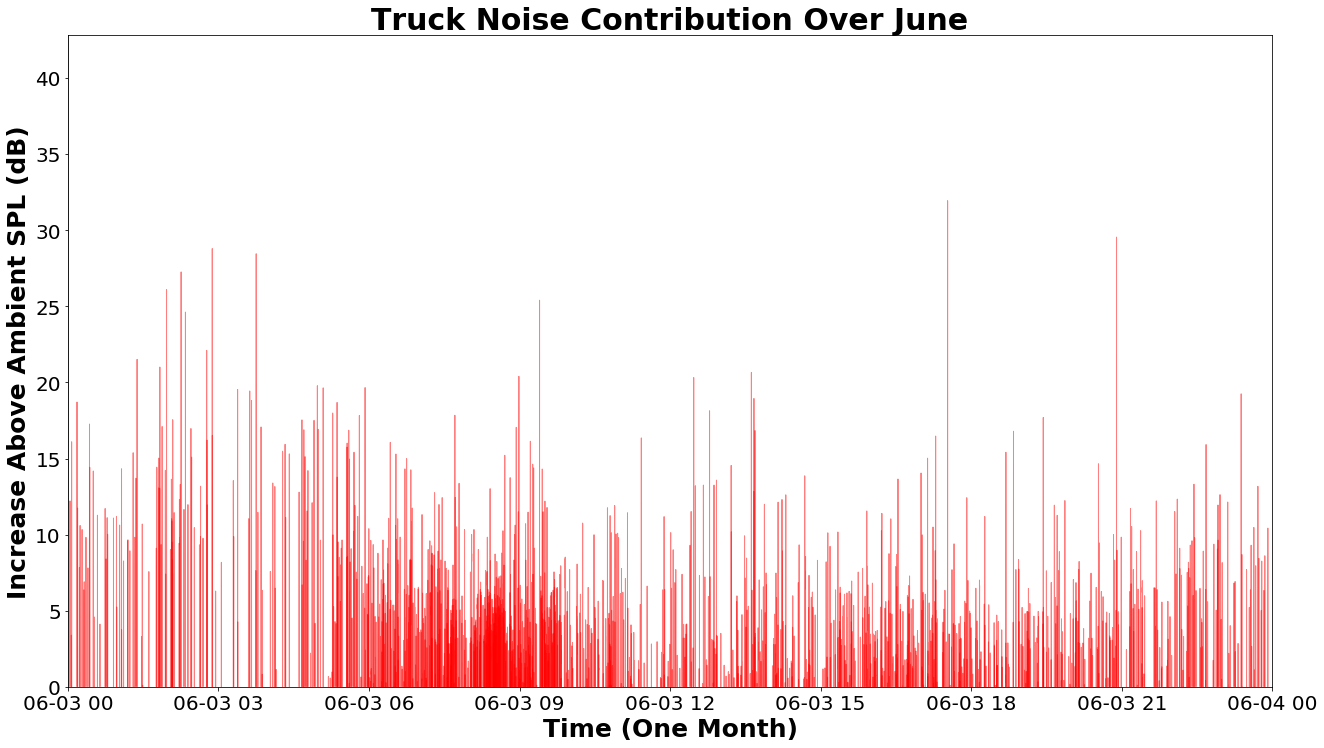

In [209]:
plot_truck_clusters_normalized_final\
(removed_all_joined_df_cut_median['2019-06-03 00:00:00-04:00':'2019-06-04 00:00:00-04:00'], \
                            7, 1, 10, 2, 'mean')

In [ ]:
# plot_truck_normalized_final\
# (removed_all_joined_df_cut_median['2019-06-04 00:00:00-04:00':'2019-06-05 00:00:00-04:00'], \
#                             7, 1, 10, 2, 'mean')

In [ ]:
# plot_truck_normalized_final\
# (removed_all_joined_df_cut_median['2019-06-10 08:00:00-04:00':'2019-06-17 08:00:00-04:00'], \
#                             7, 1, 10, 2, 'mean')

In [ ]:
# plot_truck_normalized_final\
# (removed_all_joined_df_cut_median['2019-06-01 08:00:00-04:00':'2019-06-30 08:00:00-04:00'], \
#                             7, 1, 10, 2, 'mean')